<a href="https://colab.research.google.com/github/KUNALCHAVAN1234/deep-learning/blob/main/CordiBehaviour_Group_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize
from sentence_transformers import SentenceTransformer, util
import numpy as np
import nltk

# New section

In [12]:

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:
#Downloading and Saving it to Drive

In [14]:
import os, glob
print("Working dir:", os.getcwd())
print("Files in /content:")
for f in sorted(glob.glob("/content/*")):
    print(" -", f)


Working dir: /content
Files in /content:
 - /content/dev.json
 - /content/sample_data
 - /content/test.json
 - /content/train.json


In [15]:
import json
from pathlib import Path

def load_json_records(path: str):
    path = Path(path)
    text = path.read_text(encoding="utf-8", errors="ignore").strip()
    if not text:
        return []
    # JSON array format: [ {...}, {...} ]
    if text[0] == "[":
        return json.loads(text)
    # JSONL format: one JSON per line
    records = []
    for line in text.splitlines():
        line = line.strip()
        if line:
            records.append(json.loads(line))
    return records


In [16]:
train_path = "/content/train.json"
dev_path   = "/content/dev.json"
test_path  = "/content/test.json"

train = load_json_records(train_path)
dev   = load_json_records(dev_path)
test  = load_json_records(test_path)

print("Loaded:")
print(" train users:", len(train))
print(" dev users  :", len(dev))
print(" test users :", len(test))


Loaded:
 train users: 8278
 dev users  : 2365
 test users : 1183


In [17]:
sample = train[0]
print("Top-level keys:", list(sample.keys()))
print("ID:", sample.get("ID"))
print("Has label?:", "label" in sample, "value:", sample.get("label"))
print("Tweet type:", type(sample.get("tweet")))
print("Neighbor type:", type(sample.get("neighbor")))
print("Domain:", sample.get("domain"))


Top-level keys: ['ID', 'profile', 'tweet', 'neighbor', 'domain', 'label']
ID: 17461978
Has label?: True value: 0
Tweet type: <class 'list'>
Neighbor type: <class 'NoneType'>
Domain: ['Politics', 'Business', 'Entertainment']


In [18]:
def label_coverage(records):
    has = sum(("label" in r and r.get("label") is not None) for r in records)
    return has, len(records)

for name, recs in [("train", train), ("dev", dev), ("test", test)]:
    has, total = label_coverage(recs)
    print(f"{name}: labeled {has}/{total} ({has/total:.3f})")


train: labeled 8278/8278 (1.000)
dev: labeled 2365/2365 (1.000)
test: labeled 1183/1183 (1.000)


In [19]:
def find_first_nonnull_neighbor(records):
    for r in records:
        n = r.get("neighbor", None)
        if n is not None:
            return n
    return None

n_train = find_first_nonnull_neighbor(train)
print("Example non-null neighbor (train):", n_train)
print("Type:", type(n_train))


Example non-null neighbor (train): {'following': ['170861207', '23970102', '47293791', '29458079', '17995040', '259001548', '818876014390603776', '314792669', '21829541', '471672239'], 'follower': []}
Type: <class 'dict'>


In [20]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

OUT_DIR = Path("/content/out")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def strip_str(x):
    return x.strip() if isinstance(x, str) else x

def to_int(x):
    if x is None: return None
    if isinstance(x, (int, np.integer)): return int(x)
    if isinstance(x, str):
        s = x.strip().replace(",", "")
        if s.lower() in ("none","null",""): return None
        try: return int(float(s))
        except: return None
    return None

def to_bool(x):
    if x is None: return None
    if isinstance(x, bool): return x
    if isinstance(x, str):
        s = x.strip().lower()
        if s in ("true","1","yes"): return True
        if s in ("false","0","no"): return False
    return None

def parse_follow_edges(user_id, neighbor_dict):
    # neighbor_dict has {'following': [...], 'follower': [...]}
    edges = []
    if neighbor_dict is None:
        return edges

    following = neighbor_dict.get("following", []) or []
    follower  = neighbor_dict.get("follower", []) or []

    # user -> following
    for v in following:
        v = str(strip_str(v))
        if v and v != user_id:
            edges.append((user_id, v))

    # follower -> user
    for v in follower:
        v = str(strip_str(v))
        if v and v != user_id:
            edges.append((v, user_id))

    return edges

def records_to_frames(records, split_name):
    user_rows = []
    tweet_rows = []
    edge_rows = []

    for rec in tqdm(records, desc=f"Processing {split_name}"):
        user_id = str(strip_str(rec.get("ID","")))
        if not user_id:
            continue

        profile = rec.get("profile", {}) or {}
        label = to_int(rec.get("label", None))  # 0 human, 1 bot

        user_rows.append({
            "user_id": user_id,
            "split": split_name,
            "label": label,
            "domain_raw": rec.get("domain", None),
            "followers_count": to_int(profile.get("followers_count")),
            "friends_count": to_int(profile.get("friends_count")),
            "listed_count": to_int(profile.get("listed_count")),
            "statuses_count": to_int(profile.get("statuses_count")),
            "verified": to_bool(profile.get("verified")),
            "profile_created_at": strip_str(profile.get("created_at")),
            "screen_name": strip_str(profile.get("screen_name")),
        })

        # Tweets: list[str] or list[dict]
        tweets = rec.get("tweet", []) or []
        if isinstance(tweets, list):
            for i, tw in enumerate(tweets):
                if isinstance(tw, str):
                    text = tw.strip()
                    created_at = None
                elif isinstance(tw, dict):
                    text = (tw.get("text") or tw.get("full_text") or "").strip()
                    created_at = strip_str(tw.get("created_at"))
                else:
                    continue

                if text:
                    tweet_rows.append({
                        "user_id": user_id,
                        "split": split_name,
                        "tweet_idx": i,
                        "text": text,
                        "tweet_created_at": created_at
                    })

        # Follow edges
        neighbor = rec.get("neighbor", None)
        for src, dst in parse_follow_edges(user_id, neighbor):
            edge_rows.append({"src_user_id": src, "dst_user_id": dst, "edge_type": "follow"})

    users_df = pd.DataFrame(user_rows).drop_duplicates(subset=["user_id","split"])
    tweets_df = pd.DataFrame(tweet_rows)
    edges_df = pd.DataFrame(edge_rows).drop_duplicates()

    return users_df, tweets_df, edges_df

users_train, tweets_train, edges_train = records_to_frames(train, "train")
users_dev, tweets_dev, edges_dev       = records_to_frames(dev, "dev")
users_test, tweets_test, edges_test    = records_to_frames(test, "test")

users = pd.concat([users_train, users_dev, users_test], ignore_index=True)
tweets = pd.concat([tweets_train, tweets_dev, tweets_test], ignore_index=True)
edges_follow = pd.concat([edges_train, edges_dev, edges_test], ignore_index=True).drop_duplicates()

print("Users:", len(users), "| Tweets:", len(tweets), "| Follow edges:", len(edges_follow))
print("Bot labels distribution (0=human,1=bot):")
print(users.drop_duplicates(subset=["user_id"])["label"].value_counts())

users.to_parquet(OUT_DIR / "users.parquet", index=False)
tweets.to_parquet(OUT_DIR / "tweets.parquet", index=False)
edges_follow.to_parquet(OUT_DIR / "edges_follow.parquet", index=False)
print("Saved:", OUT_DIR)


Processing test: 100%|██████████| 1183/1183 [00:00<00:00, 9812.51it/s] 


Users: 11826 | Tweets: 1999788 | Follow edges: 208381
Bot labels distribution (0=human,1=bot):
label
1    6589
0    5237
Name: count, dtype: int64
Saved: /content/out


User embeddings MiniLM

In [21]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import torch
from pathlib import Path

OUT_DIR = Path("/content/out")

MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model = SentenceTransformer(MODEL_NAME, device=device)

# Initiallly it was 100 but it is taking too much ram and gpu so lowered it to 50 .dont know exactly how the results will be
TWEETS_PER_USER = 50

tweets_sorted = tweets.sort_values(["user_id", "tweet_idx"])
tweets_limited = tweets_sorted.groupby("user_id").head(TWEETS_PER_USER).reset_index(drop=True)

texts = tweets_limited["text"].astype(str).tolist()

tweet_emb = model.encode(
    texts,
    batch_size=256, #inc. from 128  too much time
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

user_ids = tweets_limited["user_id"].unique().tolist()
user_vecs = []

for uid in tqdm(user_ids, desc="Mean-pooling tweets → user embedding"):
    idx = tweets_limited.index[tweets_limited["user_id"] == uid].to_numpy()
    v = tweet_emb[idx].mean(axis=0)
    v = v / (np.linalg.norm(v) + 1e-12)
    user_vecs.append(v)

user_vecs = np.vstack(user_vecs)
user_index = pd.DataFrame({"user_id": user_ids})

np.save(OUT_DIR / "user_embeddings.npy", user_vecs)
user_index.to_csv(OUT_DIR / "user_index.csv", index=False)

print("Saved user embeddings:", user_vecs.shape)
print("Files:", (OUT_DIR / "user_embeddings.npy"), (OUT_DIR / "user_index.csv"))


Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2110 [00:00<?, ?it/s]

Mean-pooling tweets → user embedding: 100%|██████████| 11746/11746 [08:11<00:00, 23.91it/s]


Saved user embeddings: (11746, 384)
Files: /content/out/user_embeddings.npy /content/out/user_index.csv


top-k nearest neighbors(txt similairity edges)

In [22]:
from sklearn.neighbors import NearestNeighbors

TOP_K = 10  # per user

# user_vecs are normalized; cosine distance works well
nn = NearestNeighbors(n_neighbors=TOP_K + 1, metric="cosine")
nn.fit(user_vecs)

dist, ind = nn.kneighbors(user_vecs)

rows = []
for i in range(user_vecs.shape[0]):
    src = user_ids[i]
    for d, j in zip(dist[i], ind[i]):
        if j == i:
            continue
        dst = user_ids[j]
        cos_sim = 1.0 - float(d)
        rows.append({
            "src_user_id": src,
            "dst_user_id": dst,
            "edge_type": "text_sim",
            "weight": cos_sim
        })

edges_textsim = pd.DataFrame(rows)
edges_textsim.to_parquet(OUT_DIR / "edges_textsim.parquet", index=False)

print("Text-sim edges:", len(edges_textsim))
print("Saved:", OUT_DIR / "edges_textsim.parquet")


Text-sim edges: 117460
Saved: /content/out/edges_textsim.parquet


In [23]:
edges_follow = pd.read_parquet(OUT_DIR / "edges_follow.parquet")
edges_textsim = pd.read_parquet(OUT_DIR / "edges_textsim.parquet")

edges_fused = pd.concat([edges_follow, edges_textsim], ignore_index=True)
edges_fused.to_parquet(OUT_DIR / "edges_fused.parquet", index=False)

print("Follow edges:", len(edges_follow))
print("TextSim edges:", len(edges_textsim))
print("Fused edges:", len(edges_fused))
print("Saved:", OUT_DIR / "edges_fused.parquet")


Follow edges: 208381
TextSim edges: 117460
Fused edges: 325841
Saved: /content/out/edges_fused.parquet


aligning the three dataset with embeddings

In [24]:
import numpy as np
import pandas as pd
from pathlib import Path

OUT_DIR = Path("/content/out")

users = pd.read_parquet(OUT_DIR / "users.parquet")
user_index = pd.read_csv(OUT_DIR / "user_index.csv")
X = np.load(OUT_DIR / "user_embeddings.npy")

# Map user_id -> row in X
uid_to_row = {uid: i for i, uid in enumerate(user_index["user_id"].astype(str).tolist())}

# Build a dataframe restricted to users that have embeddings
u = users.drop_duplicates(subset=["user_id"]).copy()
u["user_id"] = u["user_id"].astype(str)
u["emb_row"] = u["user_id"].map(uid_to_row)

u = u[u["emb_row"].notna()].copy()
u["emb_row"] = u["emb_row"].astype(int)

print("Users with embeddings:", len(u), "out of", users["user_id"].nunique())
print("Splits:", u["split"].value_counts().to_dict())
print("Label distribution:", u["label"].value_counts().to_dict())


Users with embeddings: 11746 out of 11826
Splits: {'train': 8223, 'dev': 2350, 'test': 1173}
Label distribution: {1: 6561, 0: 5185}


tran logisctic regression

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

def split_xy(df, split_name):
    d = df[df["split"] == split_name]
    Xs = X[d["emb_row"].to_numpy()]
    ys = d["label"].astype(int).to_numpy()
    return Xs, ys, d

X_train, y_train, df_train = split_xy(u, "train")
X_dev,   y_dev,   df_dev   = split_xy(u, "dev")
X_test,  y_test,  df_test  = split_xy(u, "test")

clf = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1)
clf.fit(X_train, y_train)

def eval_split(name, Xs, ys):
    proba = clf.predict_proba(Xs)[:, 1]
    pred = (proba >= 0.5).astype(int)
    print("\n===", name, "===")
    print("ROC-AUC:", roc_auc_score(ys, proba))
    print(classification_report(ys, pred, digits=4))
    print("Confusion matrix [tn fp; fn tp]:\n", confusion_matrix(ys, pred))

eval_split("DEV", X_dev, y_dev)
eval_split("TEST", X_test, y_test)



=== DEV ===
ROC-AUC: 0.8017729343828333
              precision    recall  f1-score   support

           0     0.6872    0.7400    0.7127      1054
           1     0.7745    0.7261    0.7495      1296

    accuracy                         0.7323      2350
   macro avg     0.7309    0.7331    0.7311      2350
weighted avg     0.7353    0.7323    0.7330      2350

Confusion matrix [tn fp; fn tp]:
 [[780 274]
 [355 941]]

=== TEST ===
ROC-AUC: 0.7729408941666716
              precision    recall  f1-score   support

           0     0.6922    0.7217    0.7066       539
           1     0.7545    0.7271    0.7406       634

    accuracy                         0.7246      1173
   macro avg     0.7233    0.7244    0.7236      1173
weighted avg     0.7259    0.7246    0.7250      1173

Confusion matrix [tn fp; fn tp]:
 [[389 150]
 [173 461]]


In [26]:
test_proba = clf.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= 0.5).astype(int)

pred_df = df_test[["user_id", "split", "label"]].copy()
pred_df["bot_proba"] = test_proba
pred_df["bot_pred"] = test_pred

pred_df.to_parquet(OUT_DIR / "baseline_text_predictions_test.parquet", index=False)
print("Saved:", OUT_DIR / "baseline_text_predictions_test.parquet")
pred_df.head()


Saved: /content/out/baseline_text_predictions_test.parquet


,user_id,split,label,bot_proba,bot_pred
10643,1188812492010487808,test,1,0.808982,1
10644,155659213,test,0,0.161742,0
10645,147725246,test,0,0.345755,0
10646,1296248637194895360,test,1,0.202902,0
10647,1339835893,test,0,0.340662,0


In [27]:
from pathlib import Path

OUT_DIR = Path("/content/out")

# Load test predictions created earlier (A3)
pred_path = OUT_DIR / "baseline_text_predictions_test.parquet"
pred_df = pd.read_parquet(pred_path)

print(pred_df.head())
print("Rows:", len(pred_df))
print("Label distribution:", pred_df["label"].value_counts().to_dict())


               user_id split  label  bot_proba  bot_pred
0  1188812492010487808  test      1   0.808982         1
1            155659213  test      0   0.161742         0
2            147725246  test      0   0.345755         0
3  1296248637194895360  test      1   0.202902         0
4           1339835893  test      0   0.340662         0
Rows: 1173
Label distribution: {1: 634, 0: 539}


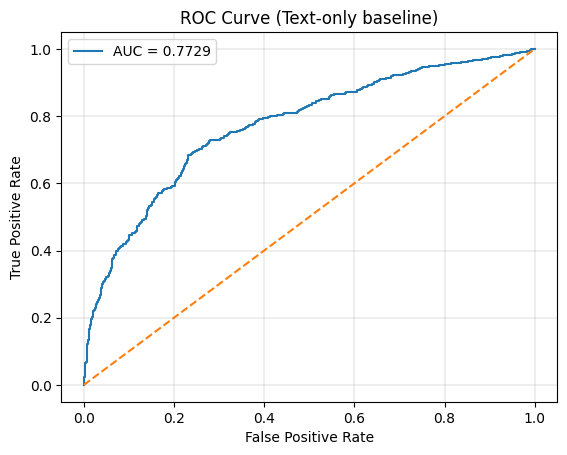

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_true = pred_df["label"].astype(int).to_numpy()
y_score = pred_df["bot_proba"].to_numpy()

fpr, tpr, _ = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Text-only baseline)")
plt.legend()
plt.grid(True, linewidth=0.3)
plt.show()


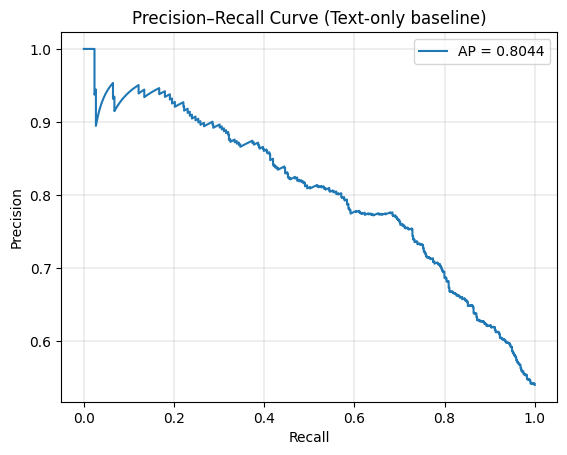

In [29]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, _ = precision_recall_curve(y_true, y_score)
ap = average_precision_score(y_true, y_score)

plt.figure()
plt.plot(rec, prec, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Text-only baseline)")
plt.legend()
plt.grid(True, linewidth=0.3)
plt.show()


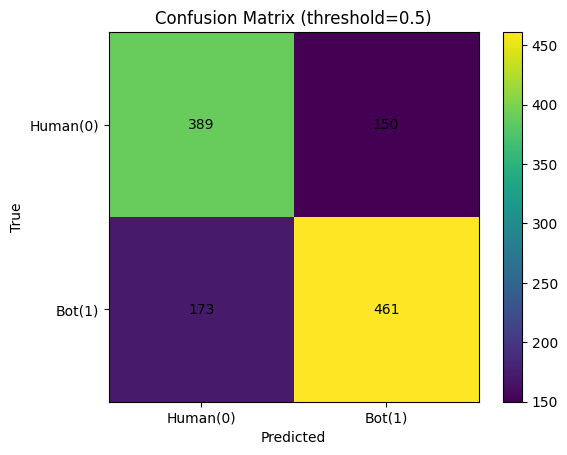

In [30]:
from sklearn.metrics import confusion_matrix

y_pred = (y_score >= 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)  # [[tn, fp],[fn,tp]]

plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (threshold=0.5)")
plt.xticks([0, 1], ["Human(0)", "Bot(1)"])
plt.yticks([0, 1], ["Human(0)", "Bot(1)"])
plt.xlabel("Predicted")
plt.ylabel("True")

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.colorbar()
plt.show()


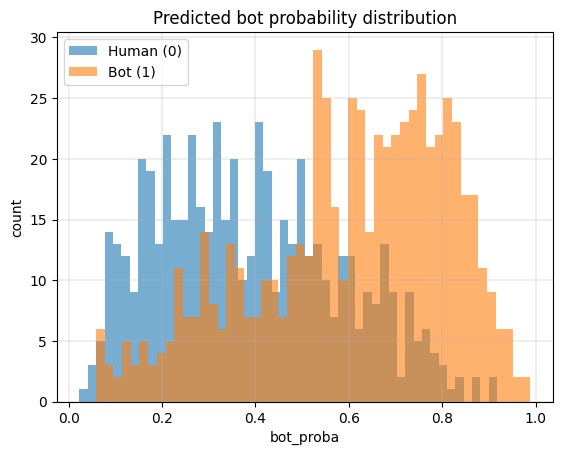

In [31]:
plt.figure()
plt.hist(y_score[y_true==0], bins=50, alpha=0.6, label="Human (0)")
plt.hist(y_score[y_true==1], bins=50, alpha=0.6, label="Bot (1)")
plt.title("Predicted bot probability distribution")
plt.xlabel("bot_proba")
plt.ylabel("count")
plt.legend()
plt.grid(True, linewidth=0.3)
plt.show()


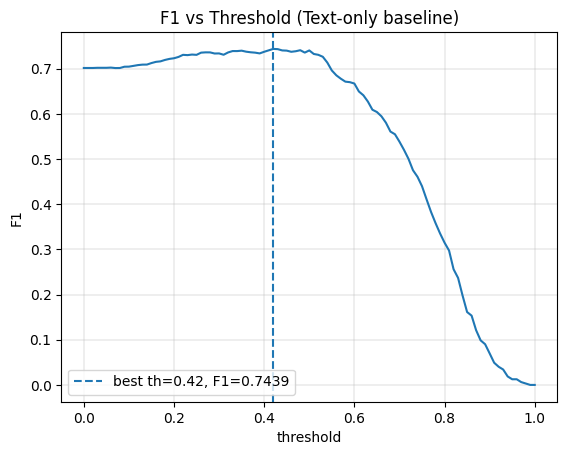

In [32]:
from sklearn.metrics import f1_score

thresholds = np.linspace(0.0, 1.0, 101)
f1s = []
for th in thresholds:
    yp = (y_score >= th).astype(int)
    f1s.append(f1_score(y_true, yp))

best_idx = int(np.argmax(f1s))
best_th = thresholds[best_idx]
best_f1 = f1s[best_idx]

plt.figure()
plt.plot(thresholds, f1s)
plt.axvline(best_th, linestyle="--", label=f"best th={best_th:.2f}, F1={best_f1:.4f}")
plt.title("F1 vs Threshold (Text-only baseline)")
plt.xlabel("threshold")
plt.ylabel("F1")
plt.legend()
plt.grid(True, linewidth=0.3)
plt.show()

Coordination-style clusters (community detection on fused graph)

In [40]:
!pip -q install --upgrade python-louvain

import networkx as nx
import community as community_louvain
import numpy as np
import pandas as pd
from pathlib import Path

OUT_DIR = Path("/content/out")


In [41]:
edges_follow = pd.read_parquet(OUT_DIR / "edges_follow.parquet")
edges_textsim = pd.read_parquet(OUT_DIR / "edges_textsim.parquet")
users = pd.read_parquet(OUT_DIR / "users.parquet").drop_duplicates(subset=["user_id"])[["user_id","label","split"]].copy()
users["user_id"] = users["user_id"].astype(str)

# Build undirected weighted graph for Louvain
G = nx.Graph()

# Add nodes (optional but helps ensure isolated nodes are included)
for uid in users["user_id"].tolist():
    G.add_node(uid)

# Add follow edges (weight=1.0)
for r in edges_follow.itertuples(index=False):
    G.add_edge(str(r.src_user_id), str(r.dst_user_id), weight=1.0, etype="follow")

# Add text-sim edges (use their cosine weight)
for r in edges_textsim.itertuples(index=False):
    # keep the strongest signal; weight already cosine similarity
    G.add_edge(str(r.src_user_id), str(r.dst_user_id), weight=float(r.weight), etype="text_sim")

print("Graph nodes:", G.number_of_nodes())
print("Graph edges:", G.number_of_edges())


Graph nodes: 191582
Graph edges: 308567


In [43]:
import community.community_louvain as community_louvain
import networkx as nx

print("Imported python-louvain as community_louvain")
print("Has best_partition?:", hasattr(community_louvain, "best_partition"))


Imported python-louvain as community_louvain
Has best_partition?: True


In [44]:
# Louvain partition: node -> community_id
partition = community_louvain.best_partition(G, weight="weight", random_state=42)

comm_df = pd.DataFrame({"user_id": list(partition.keys()), "community": list(partition.values())})
comm_df = comm_df.merge(users, on="user_id", how="left")

print("Num communities:", comm_df["community"].nunique())
print("Community size stats:")
print(comm_df["community"].value_counts().describe())


Num communities: 50
Community size stats:
count       50.000000
mean      3831.640000
std       3289.496077
min         21.000000
25%       1323.500000
50%       2553.000000
75%       6120.750000
max      12653.000000
Name: count, dtype: float64


In [45]:
# Prepare for quick lookup
node_to_comm = partition

# Filter text-sim edges only
ts = edges_textsim.copy()
ts["src_user_id"] = ts["src_user_id"].astype(str)
ts["dst_user_id"] = ts["dst_user_id"].astype(str)

# Keep edges where both endpoints are in same community
ts["c_src"] = ts["src_user_id"].map(node_to_comm)
ts["c_dst"] = ts["dst_user_id"].map(node_to_comm)
ts_in = ts[ts["c_src"].notna() & (ts["c_src"] == ts["c_dst"])].copy()
ts_in.rename(columns={"c_src":"community"}, inplace=True)

# Community sizes and bot fraction
sizes = comm_df.groupby("community").size().rename("size")
bot_frac = comm_df.groupby("community")["label"].mean().rename("bot_fraction")  # label is 0/1

# TextSim stats
avg_textsim = ts_in.groupby("community")["weight"].mean().rename("avg_textsim_inside")
count_textsim = ts_in.groupby("community").size().rename("num_textsim_edges")

stats = pd.concat([sizes, bot_frac, avg_textsim, count_textsim], axis=1).fillna(0)

# Approx density of text-sim edges inside community
# possible undirected pairs = n*(n-1)/2 ; our text_sim edges are directed in file, but we treat as signal count
stats["possible_pairs"] = stats["size"] * (stats["size"] - 1) / 2
stats["textsim_density"] = stats["num_textsim_edges"] / (stats["possible_pairs"] + 1e-9)

# Simple coordination score (tunable): emphasize strong similarity + density, require some size
stats["coord_score"] = (stats["avg_textsim_inside"] * 0.7 + stats["textsim_density"] * 0.3) * np.log1p(stats["size"])

stats_sorted = stats.sort_values("coord_score", ascending=False)
stats_sorted.head(10)


,size,bot_fraction,avg_textsim_inside,num_textsim_edges,possible_pairs,textsim_density,coord_score
community,,,,,,,
1,12653,0.847932,0.915610,6977.0,80042878.0,0.000087,6.054270
33,11101,0.238095,0.915636,5809.0,61610550.0,0.000094,5.970594
22,8898,0.753176,0.902836,3961.0,39582753.0,0.000100,5.747354
10,10406,0.540230,0.870521,5732.0,54137215.0,0.000106,5.637062
3,7359,0.711165,0.896643,2967.0,27073761.0,0.000110,5.588773
48,9095,0.452893,0.860390,4487.0,41354965.0,0.000108,5.490370
38,6439,0.523161,0.879969,2219.0,20727141.0,0.000107,5.402583
26,7328,0.570175,0.864586,3129.0,26846128.0,0.000117,5.386440
9,6941,0.596811,0.862398,2337.0,24085270.0,0.000097,5.340003


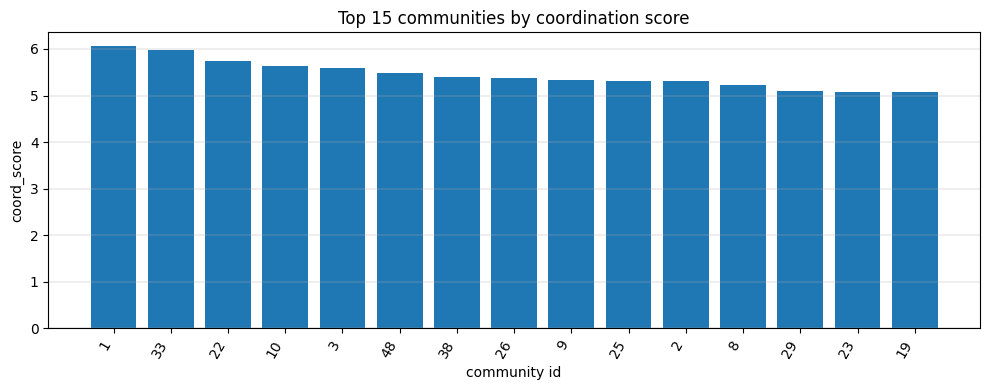

In [47]:
import matplotlib.pyplot as plt

topN = 15
top = stats_sorted.head(topN).copy()

plt.figure(figsize=(10, 4))
plt.bar(range(topN), top["coord_score"].to_numpy())
plt.xticks(range(topN), [str(c) for c in top.index.to_list()], rotation=60, ha="right")
plt.title(f"Top {topN} communities by coordination score")
plt.xlabel("community id")
plt.ylabel("coord_score")
plt.grid(True, axis="y", linewidth=0.3)
plt.tight_layout()
plt.show()


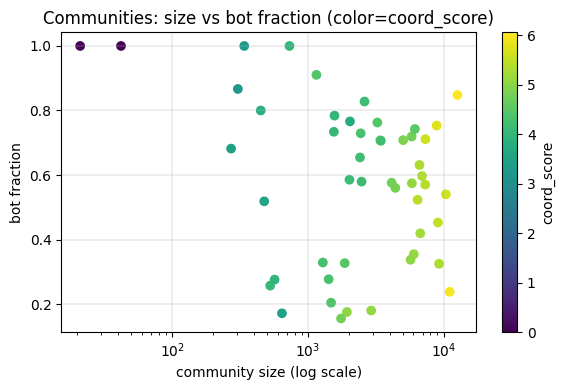

In [48]:
import numpy as np

dfp = stats_sorted.reset_index().rename(columns={"index":"community"}).copy()

x = dfp["size"].to_numpy()
y = dfp["bot_fraction"].to_numpy()
c = dfp["coord_score"].to_numpy()

plt.figure(figsize=(6, 4))
sc = plt.scatter(x, y, c=c)
plt.xscale("log")
plt.xlabel("community size (log scale)")
plt.ylabel("bot fraction")
plt.title("Communities: size vs bot fraction (color=coord_score)")
plt.colorbar(sc, label="coord_score")
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()


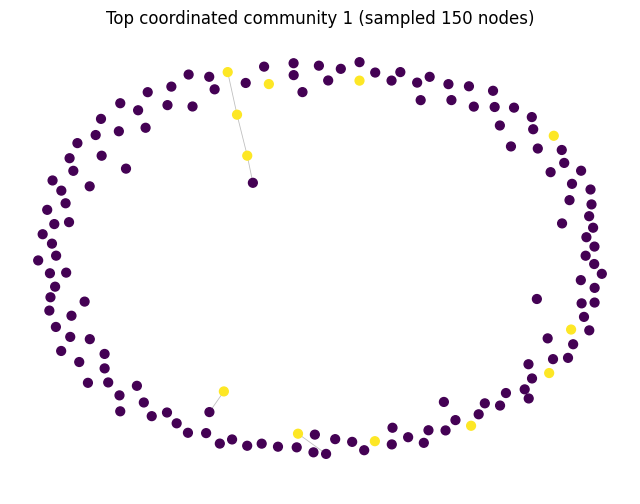

In [49]:
import random
import networkx as nx
import matplotlib.pyplot as plt

# Pick the top community by coord_score
top_comm = stats_sorted.index[0]
sub_users = comm_df[comm_df["community"] == top_comm]["user_id"].astype(str).tolist()

# Sample nodes to keep it readable
MAX_NODES = 150
if len(sub_users) > MAX_NODES:
    sub_users = random.sample(sub_users, MAX_NODES)

H = G.subgraph(sub_users).copy()

# Node colors: bot=1, human=0, unknown=None
label_map = {str(r.user_id): r.label for r in users.itertuples(index=False)}
node_colors = []
for n in H.nodes():
    lab = label_map.get(str(n), None)
    node_colors.append(1 if lab == 1 else 0)

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(H, seed=42, k=0.25)

nx.draw_networkx_nodes(H, pos, node_size=40, node_color=node_colors)
nx.draw_networkx_edges(H, pos, alpha=0.25, width=0.6)

plt.title(f"Top coordinated community {top_comm} (sampled {H.number_of_nodes()} nodes)")
plt.axis("off")
plt.show()


In [46]:
tweets = pd.read_parquet(OUT_DIR / "tweets.parquet")
tweets["user_id"] = tweets["user_id"].astype(str)

top_comms = stats_sorted.head(5).index.tolist()
print("Top communities by coordination score:", top_comms)

for c in top_comms:
    sub_users = comm_df[comm_df["community"] == c]["user_id"].tolist()
    sub_stats = stats_sorted.loc[c]
    print("\n==============================")
    print(f"Community {c}")
    print(f"Size: {int(sub_stats['size'])}")
    print(f"Bot fraction: {sub_stats['bot_fraction']:.3f}")
    print(f"Avg text-sim inside: {sub_stats['avg_textsim_inside']:.3f}")
    print(f"Text-sim density: {sub_stats['textsim_density']:.6f}")
    print(f"Coord score: {sub_stats['coord_score']:.4f}")

    # Sample up to 15 tweets from this community
    sample_tweets = tweets[tweets["user_id"].isin(sub_users)].head(15)["text"].tolist()
    print("\nSample tweets:")
    for t in sample_tweets[:10]:
        print(" -", t[:160].replace("\n"," "))


Top communities by coordination score: [1, 33, 22, 10, 3]

Community 1
Size: 12653
Bot fraction: 0.848
Avg text-sim inside: 0.916
Text-sim density: 0.000087
Coord score: 6.0543

Sample tweets:
 - RT @realDonaldTrump: THANK YOU #RNC2020! https://t.co/SQXxesAU0i
 - Great takeaways from last night's Republican National Convention.  https://t.co/JwquHxxSBP
 - RT @KatrinaPierson: First night of #GOP convention delivers nearly six times more views than start of Democrats' event on C-SPAN livestream…
 - RT @abby_draiss16: This is one of the most incredible videos I’ve seen.  God bless America 🇺🇸 #RNCConvention
 - RT @DanaPerino: Production of the rnc convention is very good so far. Impressive. Loved the quick roll call of the states.
 - Great work from the Parscale team. Very proud of our team and quality of work. Great night one so far! https://t.co/PmGZQkRZBZ
 - Can’t believe I have to watch the convention on @CNN. Unbelievable. @FoxNews
 - RT @DanScavino: https://t.co/GSoTm8HNSi
 - I just 

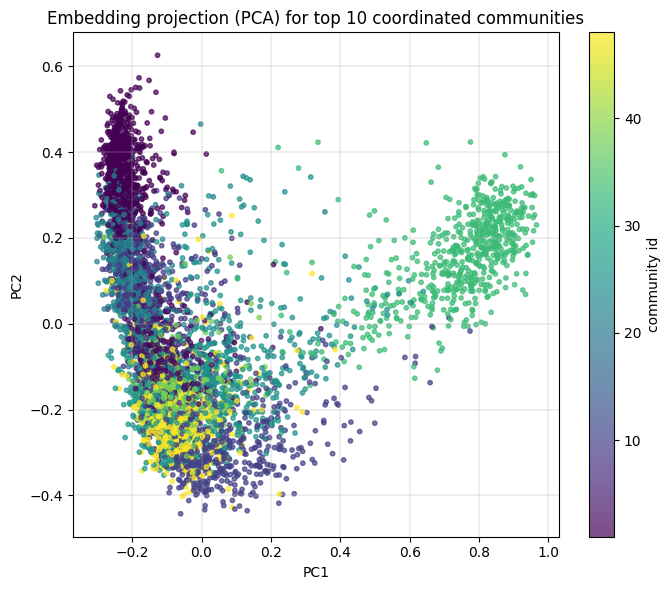

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# community mapping
comm_map = dict(zip(comm_df["user_id"].astype(str), comm_df["community"].astype(int)))

# choose top 10 communities by coord_score
top_comms = stats_sorted.head(10).index.tolist()

# filter to users in those communities
user_index = pd.read_csv(OUT_DIR / "user_index.csv")
X = np.load(OUT_DIR / "user_embeddings.npy")
user_index["community"] = user_index["user_id"].astype(str).map(comm_map)

mask = user_index["community"].isin(top_comms)
X_proj = PCA(n_components=2, random_state=42).fit_transform(X[mask.to_numpy()])
c = user_index.loc[mask, "community"].to_numpy()

plt.figure(figsize=(7, 6))
sc = plt.scatter(X_proj[:, 0], X_proj[:, 1], c=c, s=10, alpha=0.7)
plt.title("Embedding projection (PCA) for top 10 coordinated communities")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(sc, label="community id")
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load embeddings + index
user_index = pd.read_csv(OUT_DIR / "/content/out/user_index.csv")
X = np.load(OUT_DIR / "/content/out/user_embeddings.npy")

# Map label onto embedding users
users_u = pd.read_parquet(OUT_DIR / "/content/out/users.parquet").drop_duplicates(subset=["user_id"])[["user_id","label"]].copy()
users_u["user_id"] = users_u["user_id"].astype(str)

emb_df = user_index.merge(users_u, on="user_id", how="left")
mask = emb_df["label"].notna()

X2 = PCA(n_components=2, random_state=42).fit_transform(X[mask.to_numpy()])
y2 = emb_df.loc[mask, "label"].astype(int).to_numpy()

plt.figure(figsize=(6, 5))
plt.scatter(X2[y2==0, 0], X2[y2==0, 1], s=8, alpha=0.6, label="Human (0)")
plt.scatter(X2[y2==1, 0], X2[y2==1, 1], s=8, alpha=0.6, label="Bot (1)")
plt.title("User embedding projection (PCA) colored by label")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()


ValueError: You are trying to merge on int64 and object columns for key 'user_id'. If you wish to proceed you should use pd.concat

In [54]:

import pandas as pd
import numpy as np
from pathlib import Path

OUT_DIR = Path("/content/out")

tweets = pd.read_parquet(OUT_DIR / "tweets.parquet")
print("tweets columns:", tweets.columns.tolist())

# Check presence + coverage of tweet_created_at (from earlier parsing)
ts_nonnull = tweets["tweet_created_at"].notna().mean() if "tweet_created_at" in tweets.columns else 0.0
print(f"tweet_created_at non-null ratio: {ts_nonnull:.4f}")

if ts_nonnull > 0:
    tweets["t"] = pd.to_datetime(tweets["tweet_created_at"], errors="coerce", utc=True)
    valid_ratio = tweets["t"].notna().mean()
    print(f"Parsed timestamp valid ratio: {valid_ratio:.4f}")
    print("Example timestamps:", tweets["t"].dropna().head(5).astype(str).tolist())
else:
    print("\nNo per-tweet timestamps detected in tweets.parquet.")
    print("This typically means tweets were stored as plain strings in the JSON (no created_at field).")


tweets columns: ['user_id', 'split', 'tweet_idx', 'text', 'tweet_created_at']
tweet_created_at non-null ratio: 0.0000

No per-tweet timestamps detected in tweets.parquet.
This typically means tweets were stored as plain strings in the JSON (no created_at field).


In [59]:
import pandas as pd
from pathlib import Path

OUT_DIR = Path("/content/out")

tweets = pd.read_parquet(OUT_DIR / "tweets.parquet")
users  = pd.read_parquet(OUT_DIR / "users.parquet")

print("\n=== TWEETS: columns ===")
print(list(tweets.columns))

print("\n=== TWEETS: dtypes ===")
print(tweets.dtypes)

print("\n=== TWEETS: sample rows (first 3) ===")
display(tweets.head(3))

print("\n=== USERS: columns ===")
print(list(users.columns))

print("\n=== USERS: dtypes ===")
print(users.dtypes)

print("\n=== USERS: sample rows (first 3) ===")
display(users.head(3))



=== TWEETS: columns ===
['user_id', 'split', 'tweet_idx', 'text', 'tweet_created_at']

=== TWEETS: dtypes ===
user_id             object
split               object
tweet_idx            int64
text                object
tweet_created_at    object
dtype: object

=== TWEETS: sample rows (first 3) ===


,user_id,split,tweet_idx,text,tweet_created_at
0,17461978,train,0,RT @CarnivalCruise: 🎉 Are you ready to see wha...,None
1,17461978,train,1,Who has time for receipts? Not me. @epson rece...,None
2,17461978,train,2,Steady wants to encourage you to invest in you...,None



=== USERS: columns ===
['user_id', 'split', 'label', 'domain_raw', 'followers_count', 'friends_count', 'listed_count', 'statuses_count', 'verified', 'profile_created_at', 'screen_name']

=== USERS: dtypes ===
user_id               object
split                 object
label                  int64
domain_raw            object
followers_count        int64
friends_count          int64
listed_count           int64
statuses_count         int64
verified                bool
profile_created_at    object
screen_name           object
dtype: object

=== USERS: sample rows (first 3) ===


,user_id,split,label,domain_raw,followers_count,friends_count,listed_count,statuses_count,verified,profile_created_at,screen_name
0,17461978,train,0,"[Politics, Business, Entertainment]",15349596,692,45568,9798,True,Tue Nov 18 10:27:25 +0000 2008,SHAQ
1,1297437077403885568,train,1,[Politics],0,44,0,0,False,Sun Aug 23 07:35:11 +0000 2020,JenniferFishpaw
2,17685258,train,0,"[Politics, Entertainment, Sports]",762839,475,3201,5518,True,Thu Nov 27 18:47:32 +0000 2008,parscale


In [55]:

# checking:: are tweets objects in raw JSON?

def detect_tweet_object_has_created_at(records, n_users=200):
    seen = 0
    obj_count = 0
    has_created_at = 0
    examples = []
    for rec in records[:n_users]:
        tw = rec.get("tweet", None)
        if not isinstance(tw, list) or len(tw) == 0:
            continue
        for item in tw[:5]:
            seen += 1
            if isinstance(item, dict):
                obj_count += 1
                if "created_at" in item and item.get("created_at"):
                    has_created_at += 1
                    if len(examples) < 3:
                        examples.append(item.get("created_at"))
            if seen >= 1000:
                break
        if seen >= 1000:
            break
    return {"seen_items": seen, "dict_items": obj_count, "dict_with_created_at": has_created_at, "examples": examples}

# If train/dev/test are in memory, run this:
try:
    print("Train tweet structure check:", detect_tweet_object_has_created_at(train))
    print("Dev tweet structure check:", detect_tweet_object_has_created_at(dev))
    print("Test tweet structure check:", detect_tweet_object_has_created_at(test))
except NameError:
    print("train/dev/test not found in memory. Skip this check.")


Train tweet structure check: {'seen_items': 967, 'dict_items': 0, 'dict_with_created_at': 0, 'examples': []}
Dev tweet structure check: {'seen_items': 991, 'dict_items': 0, 'dict_with_created_at': 0, 'examples': []}
Test tweet structure check: {'seen_items': 956, 'dict_items': 0, 'dict_with_created_at': 0, 'examples': []}


In [56]:
#  CLUSTERS: compute "which cluster has what and why"
#    Requires: G (fused graph), partition, comm_df, stats_sorted
import re

users = pd.read_parquet(OUT_DIR / "users.parquet").drop_duplicates(subset=["user_id"])[["user_id","label","split"]].copy()
users["user_id"] = users["user_id"].astype(str)

# If partition is not defined, fail clearly
assert "partition" in globals(), "partition not found. Run community detection cell (Louvain) first."
node_to_comm = {str(k): int(v) for k, v in partition.items()}

comm_df = pd.DataFrame({"user_id": list(node_to_comm.keys()), "community": list(node_to_comm.values())})
comm_df = comm_df.merge(users, on="user_id", how="left")

# Load edges
edges_follow = pd.read_parquet(OUT_DIR / "edges_follow.parquet")
edges_textsim = pd.read_parquet(OUT_DIR / "edges_textsim.parquet")

edges_textsim["src_user_id"] = edges_textsim["src_user_id"].astype(str)
edges_textsim["dst_user_id"] = edges_textsim["dst_user_id"].astype(str)
edges_follow["src_user_id"] = edges_follow["src_user_id"].astype(str)
edges_follow["dst_user_id"] = edges_follow["dst_user_id"].astype(str)

# --- Per-community core stats ---
sizes = comm_df.groupby("community").size().rename("size")
bot_frac = comm_df.groupby("community")["label"].mean().rename("bot_fraction")

# text-sim inside-community
ts = edges_textsim.copy()
ts["c_src"] = ts["src_user_id"].map(node_to_comm)
ts["c_dst"] = ts["dst_user_id"].map(node_to_comm)
ts_in = ts[ts["c_src"].notna() & (ts["c_src"] == ts["c_dst"])].copy()
ts_in.rename(columns={"c_src":"community"}, inplace=True)

avg_textsim_inside = ts_in.groupby("community")["weight"].mean().rename("avg_textsim_inside")
num_textsim_edges = ts_in.groupby("community").size().rename("num_textsim_edges")

# follow edges inside-community
fe = edges_follow.copy()
fe["c_src"] = fe["src_user_id"].map(node_to_comm)
fe["c_dst"] = fe["dst_user_id"].map(node_to_comm)
fe_in = fe[fe["c_src"].notna() & (fe["c_src"] == fe["c_dst"])].copy()
fe_in.rename(columns={"c_src":"community"}, inplace=True)
num_follow_edges = fe_in.groupby("community").size().rename("num_follow_edges")

stats = pd.concat([sizes, bot_frac, avg_textsim_inside, num_textsim_edges, num_follow_edges], axis=1).fillna(0)
stats["possible_pairs"] = stats["size"] * (stats["size"] - 1) / 2
stats["textsim_density"] = stats["num_textsim_edges"] / (stats["possible_pairs"] + 1e-9)

# A simple "why" score: strong internal similarity + dense similarity edges + some size
stats["coord_score"] = (0.7 * stats["avg_textsim_inside"] + 0.3 * stats["textsim_density"]) * np.log1p(stats["size"])

stats_sorted = stats.sort_values("coord_score", ascending=False)
stats_sorted.head(10)


,size,bot_fraction,avg_textsim_inside,num_textsim_edges,num_follow_edges,possible_pairs,textsim_density,coord_score
community,,,,,,,,
1,12653,0.847932,0.915610,6977.0,12884,80042878.0,0.000087,6.054270
33,11101,0.238095,0.915636,5809.0,11145,61610550.0,0.000094,5.970594
22,8898,0.753176,0.902836,3961.0,8685,39582753.0,0.000100,5.747354
10,10406,0.540230,0.870521,5732.0,11115,54137215.0,0.000106,5.637062
3,7359,0.711165,0.896643,2967.0,7200,27073761.0,0.000110,5.588773
48,9095,0.452893,0.860390,4487.0,9146,41354965.0,0.000108,5.490370
38,6439,0.523161,0.879969,2219.0,6206,20727141.0,0.000107,5.402583
26,7328,0.570175,0.864586,3129.0,7264,26846128.0,0.000117,5.386440
9,6941,0.596811,0.862398,2337.0,6678,24085270.0,0.000097,5.340003


In [57]:
# =========================================================
# 4) Add CONTENT EXPLANATIONS per cluster:
#    top hashtags, urls, mentions, and frequent tokens
# =========================================================
tweets = pd.read_parquet(OUT_DIR / "tweets.parquet")
tweets["user_id"] = tweets["user_id"].astype(str)
tweets["community"] = tweets["user_id"].map(node_to_comm)

# Optional timestamp parsing if available
if "tweet_created_at" in tweets.columns and tweets["tweet_created_at"].notna().any():
    tweets["t"] = pd.to_datetime(tweets["tweet_created_at"], errors="coerce", utc=True)

hashtag_re = re.compile(r"#\w+")
mention_re = re.compile(r"@\w+")
url_re = re.compile(r"https?://\S+|www\.\S+")

def top_patterns(texts, pattern_re, topn=10):
    from collections import Counter
    c = Counter()
    for s in texts:
        c.update([m.lower() for m in pattern_re.findall(s)])
    return c.most_common(topn)

def top_tokens(texts, topn=15):
    from collections import Counter
    c = Counter()
    for s in texts:
        s = s.lower()
        # very light tokenization
        toks = re.findall(r"[a-z0-9']+", s)
        # remove ultra-common junk
        stop = set(["the","a","an","to","and","or","is","are","of","in","for","on","with","this","that","it","you","i","we","rt"])
        toks = [t for t in toks if t not in stop and len(t) > 2]
        c.update(toks)
    return c.most_common(topn)

def cluster_time_stats(df):
    # Returns time span + burstiness proxy (tweets per minute)
    if "t" not in df.columns or df["t"].notna().sum() == 0:
        return None
    d = df[df["t"].notna()].copy()
    if len(d) < 2:
        return None
    tmin, tmax = d["t"].min(), d["t"].max()
    span_min = (tmax - tmin).total_seconds() / 60.0
    if span_min <= 0:
        return {"tmin": tmin, "tmax": tmax, "span_min": 0.0, "tweets_per_min": np.nan}
    return {"tmin": tmin, "tmax": tmax, "span_min": span_min, "tweets_per_min": len(d)/span_min}

def explain_cluster(comm_id, max_users=200, max_tweets=2000):
    # users in cluster
    uids = comm_df[comm_df["community"] == comm_id]["user_id"].astype(str).tolist()
    if len(uids) > max_users:
        uids = uids[:max_users]  # cap for speed

    sub = tweets[tweets["user_id"].isin(uids)].copy()
    if len(sub) > max_tweets:
        sub = sub.head(max_tweets)

    texts = sub["text"].astype(str).tolist()

    explanation = {
        "community": comm_id,
        "num_users_used": len(uids),
        "num_tweets_used": len(texts),
        "top_hashtags": top_patterns(texts, hashtag_re, topn=10),
        "top_mentions": top_patterns(texts, mention_re, topn=10),
        "top_urls": top_patterns(texts, url_re, topn=10),
        "top_tokens": top_tokens(texts, topn=15),
        "time_stats": cluster_time_stats(sub),
    }
    return explanation

top_comms = stats_sorted.head(5).index.tolist()
for c in top_comms:
    print("\n==============================")
    print("Community:", c)
    print(stats_sorted.loc[c][["size","bot_fraction","avg_textsim_inside","textsim_density","num_follow_edges","coord_score"]].to_dict())
    expl = explain_cluster(c)
    print("Top hashtags:", expl["top_hashtags"])
    print("Top mentions:", expl["top_mentions"])
    print("Top urls:", expl["top_urls"][:5])
    print("Top tokens:", expl["top_tokens"])
    print("Time stats:", expl["time_stats"])



Community: 1
{'size': 12653.0, 'bot_fraction': 0.8479318734793188, 'avg_textsim_inside': 0.9156101240167923, 'textsim_density': 8.716578132035683e-05, 'num_follow_edges': 12884.0, 'coord_score': 6.054270349566294}
Top hashtags: [('#rnc2020', 18), ('#roadkill', 17), ('#chicago', 16), ('#trumphiresthebest', 15), ('#nottheirchildren', 12), ('#sundaythoughts', 12), ('#covid19', 9), ('#maga', 9), ('#thursdaythoughts', 9), ('#sundaymorning', 9)]
Top mentions: [('@realdonaldtrump', 246), ('@joebiden', 46), ('@teamtrump', 30), ('@reallyamerican1', 28), ('@jasonmillerindc', 20), ('@trumpwarroom', 18), ('@richardgrenell', 16), ('@tedcruz', 16), ('@realdonaldtrfan', 16), ('@potus', 15)]
Top urls: [('https://t.…', 6), ('https://t.co/…', 5), ('https://t.co/fmzjpoaeem', 4), ('https://…', 3), ('https://t.co…', 3)]
Top tokens: [('https', 822), ('trump', 258), ('amp', 254), ('realdonaldtrump', 240), ('they', 225), ('not', 225), ('have', 222), ('biden', 222), ('will', 192), ('was', 191), ('president', 

In [58]:
# =========================================================
# 5) WHY exactly is a cluster "coordinated" (explainable scores)
#    - internal text similarity strength
#    - density of similarity links
#    - optional: time coherence if timestamps exist
# =========================================================
def why_cluster(comm_id):
    row = stats_sorted.loc[comm_id]
    reasons = []
    if row["avg_textsim_inside"] > 0:
        reasons.append(f"High internal semantic similarity (avg_textsim_inside={row['avg_textsim_inside']:.3f}).")
    if row["textsim_density"] > 0:
        reasons.append(f"Dense similarity links within the group (textsim_density={row['textsim_density']:.6f}).")
    if row["num_follow_edges"] > 0:
        reasons.append(f"Accounts are socially connected (internal follow edges={int(row['num_follow_edges'])}).")
    # time coherence
    sub_users = comm_df[comm_df["community"] == comm_id]["user_id"].astype(str).tolist()
    sub = tweets[tweets["user_id"].isin(sub_users)].copy()
    if "t" in sub.columns and sub["t"].notna().sum() > 10:
        ts = cluster_time_stats(sub)
        if ts and ts["span_min"] is not None:
            reasons.append(f"Temporal concentration: tweets span ~{ts['span_min']:.1f} minutes for sampled data (tweets/min≈{ts['tweets_per_min']:.2f}).")
    return reasons

c = stats_sorted.index[0]
print("Community", c, "WHY:")
for r in why_cluster(c):
    print(" -", r)


Community 1 WHY:
 - High internal semantic similarity (avg_textsim_inside=0.916).
 - Dense similarity links within the group (textsim_density=0.000087).
 - Accounts are socially connected (internal follow edges=12884).


Cordination clusters

In [33]:
import json
from pathlib import Path

json_path = Path("/content/drive/MyDrive/Group7_Cordi_Behaviour/unprocessed_data/Twibot-20/train.json")

with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

print("Type:", type(data))
print("Length:", len(data) if hasattr(data, "__len__") else "N/A")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Group7_Cordi_Behaviour/unprocessed_data/Twibot-20/train.json'

In [34]:
import pprint

pprint.pprint(data[2])


NameError: name 'data' is not defined

In [35]:
#Saving 1st record to know the structure of the dataset (Not necessary)
print(data[0])
one_record = data[0]
out_path = Path("/content/drive/MyDrive/Group7_Cordi_Behaviour/unprocessed_data/First_Record.json")

with open(out_path, "w", encoding="utf-8") as f:
    json.dump(one_record, f, ensure_ascii=False, indent=2)

print("Saved:", out_path)

NameError: name 'data' is not defined

In [36]:
import json
import pandas as pd
from pathlib import Path

# Paths
json_path = Path("/content/drive/MyDrive/Group7_Cordi_Behaviour/unprocessed_data/Twibot-20/train.json")
csv_path  = Path("/content/drive/MyDrive/Group7_Cordi_Behaviour/unprocessed_data/Twibot-20/train.csv")

# Load JSON
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Normalize (flatten nested profile dict)
df = pd.json_normalize(data)

data_df = pd.DataFrame(columns=df.columns)

df_flat = df.explode("tweet", ignore_index=False)

# # Convert list columns into strings (CSV-friendly)
# if "tweet" in df.columns:
#     df["tweet"] = df["tweet"].apply(lambda x: " || ".join(x) if isinstance(x, list) else x)

# if "domain" in df.columns:
#     df["domain"] = df["domain"].apply(lambda x: " || ".join(x) if isinstance(x, list) else x)

# # neighbor can be null / list / dict — stringify anything complex
# if "neighbor" in df.columns:
#     df["neighbor"] = df["neighbor"].apply(lambda x: json.dumps(x) if isinstance(x, (list, dict)) else x)

# Save to CSV
data_df.to_csv(csv_path, index=False, encoding="utf-8")
df_flat.columns
df_flat= df_flat.drop(columns=[
    'profile.screen_name',
    'profile.protected',
    'profile.url',
    'profile.geo_enabled',
    'profile.contributors_enabled',
    'profile.profile_background_color',
    'profile.profile_background_image_url',
    'profile.profile_background_tile',
    'profile.profile_image_url',
    'profile.profile_image_url_https',
    'profile.profile_link_color',
    'profile.profile_sidebar_border_color',
    'profile.profile_sidebar_fill_color', 'profile.profile_text_color',
    'profile.profile_use_background_image', 'profile.has_extended_profile',
    'profile.default_profile',
    'profile.default_profile_image',
    'profile.profile_background_image_url_https',
    # 'neighbor',               # all none
    # 'neighbor.follower',      # no need for followers if neightbos are not there
    # 'neighbor.following',
    'profile.id',             # same as id
    'profile.id_str',         # id alreayd exists
    'profile.utc_offset',   # all None
    'profile.time_zone',      # al None
    'profile.lang'            # all None


])
# print(" Saved CSV to:", csv_path)
# print("CSV shape:", df.shape)
# df.head()
df_flat.columns


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Group7_Cordi_Behaviour/unprocessed_data/Twibot-20/train.json'

In [ ]:
df_flat = df_flat.dropna(subset=["tweet"])

In [ ]:
df_flat.shape
# df_flat["neighbor.following"].unique()

In [ ]:
#Data cleaning

In [ ]:
# Convert true false values to binary 0/1
df_flat['profile.is_translation_enabled'] = df_flat['profile.is_translation_enabled'].astype(str).str.strip().str.lower().map({"true": 1, "false": 0})
df_flat['profile.is_translator'] = df_flat['profile.is_translator'].astype(str).str.strip().str.lower().map({"true": 1, "false": 0})
df_flat['profile.verified'] = df_flat['profile.verified'].astype(str).str.strip().str.lower().map({"true": 1, "false": 0})



In [ ]:
df_flat["profile.is_translation_enabled"].unique()

In [ ]:
df_flat.info() #to check non null values

In [ ]:
df_flat

### Adding additional features

In [ ]:
# count retweet, if a tweet is retweeted then 1 else 0
def countRetweet(tweet):
  if tweet.startswith('RT @'):
    return 1
  return 0

df_flat['retweet'] = df_flat['tweet']
df_flat['retweet'] = df_flat['retweet'].apply(countRetweet)




In [ ]:
#Get original users of retweet (run it once)
import re
df_flat= df_flat.reset_index()
retweeted_tweets = df_flat[df_flat['retweet'] >= 1].copy()

def extract_original_user(tweet_text):
    match = re.search(r'RT @(\w+)', tweet_text)
    if match:
        return match.group(1)
    return None

retweeted_tweets['original_user'] = retweeted_tweets['tweet'].apply(extract_original_user)
df_flat['original_user'] = retweeted_tweets['original_user']


In [ ]:
# -------------------------------
# Number of Mentions in the Tweet
# -------------------------------
import re
df_flat['mentions_count'] = df_flat['tweet']
df_flat['mentions_count'] = df_flat['mentions_count'].apply(lambda x: len(re.findall(r'(?<!RT\s)@\w+', x)))

In [ ]:
# CLeaning functions (cleaning the tweet)
import re
def clean(text: str) -> str:
  pattern_urls = r"https?:\/\/\S+"
  pattern_encoding= r"((?:\\x\w+)+)"
  clean_text = re.sub(pattern_urls, '', text)
  clean_text = re.sub(pattern_encoding, '', clean_text)
  return clean_text

In [ ]:
df_flat

In [ ]:
def extract_mentioned_users(tweet):
    usernames = re.findall(r'@(\w+)', tweet)
    # Filter out 'RT' if it's captured as a mention
    usernames = [user for user in usernames if user.lower() != 'rt']
    return ', '.join(usernames)

df_flat['mentioned_users'] = df_flat['tweet'].apply(extract_mentioned_users)

In [ ]:
# Clean tweet text
df_flat["tweet_text_cleaned"] = df_flat["tweet"].apply(clean)
df_flat["tweet_text_cleaned"] = df_flat["tweet_text_cleaned"].astype(str)
df_flat


## Generate embeddings of tweet

In [ ]:
pip install -U sentence-transformers --quiet

In [ ]:
df_flat.columns

In [ ]:
"""
sentences : actual tweets
users: unique users
users_index_map: lookup table for user to their respective index
"""
sentences = list(df_flat["tweet_text_cleaned"])
# labels = list(df_flat["label"])

users = df_flat["ID"].unique()
user_index_map = {user: i for i, user in enumerate(users)}

# print(len(sentences))

print(user_index_map)





In [ ]:
def encode(sentence):
  model = SentenceTransformer("all-MiniLM-L6-v2")
  return model.encode(sentence,
    convert_to_numpy=True,
    normalize_embeddings=True)

In [ ]:

def create_embeddings(sentences):
  model = SentenceTransformer("all-MiniLM-L6-v2")
  embeddings_ = model.encode(sentences,
    convert_to_numpy=True,
    normalize_embeddings=True)
  return embeddings_

embeddings = create_embeddings(sentences)




In [ ]:
import numpy as np
np.save("tweet_embeddings_train.npy", embeddings)



## Generate similarity matrix

In [ ]:
#  generate cosine similarity for vectors
from sklearn.neighbors import NearestNeighbors

k=10
nbrs = NearestNeighbors(n_neighbors=k, metric="cosine").fit(embeddings)


In [ ]:
def get_k_neighbors(query_embedding):
  distances, indices = nbrs.kneighbors(query_embedding)
  similarities = 1 - distances  # cosine similarity
  return indices, similarities

def generate_similarity_matrix( embeddings ):
  return get_k_neighbors(embeddings)

In [ ]:
# Examlpe embedding

In [ ]:
ind, sim = get_k_neighbors( encode("forest fires").reshape(1,-1))
print(ind, sim)
for in1 in ind[0]:
  print(sentences[in1])